## NOTE: Note that the GR6J model was simulated using R and then the predicted time series was imported here for the modeling process.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, random_split, Dataset,TensorDataset
from sklearn.metrics import mean_squared_error

import random
import joblib
from google.colab import files
import matplotlib.dates as mdates

In [ ]:
import tensorflow as tf

seed = 311
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# To enforce determinism on operations
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
daily = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/SDE_driven/savè.xlsx')

discharge = daily.iloc[:1280, 0].to_numpy()
plui = daily.iloc[:1280, 1].to_numpy()
etp = daily.iloc[:1280, 2].to_numpy()

discharge1 = daily.iloc[1280:, 0].to_numpy()
plui1 = daily.iloc[1280:, 1].to_numpy()
etp1 = daily.iloc[1280:, 2].to_numpy()

In [ ]:
#Calibration data
discharge = daily.iloc[:1280, 0].to_numpy()
plui = daily.iloc[:1280, 1].to_numpy()
etp = daily.iloc[:1280, 2].to_numpy()

#Validation data
discharge1 = daily.iloc[1280:, 0].to_numpy()
plui1 = daily.iloc[1280:, 1].to_numpy()
etp1 = daily.iloc[1280:, 2].to_numpy()

In [ ]:
discharge[0]

np.float64(0.0640000030398369)

In [ ]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


GR6J

In [ ]:
GR6J = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Save/GR6J_cal_save.xlsx')
GR6J_val = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/HyMoLAP/Paper/Save/GR6J_val_save.xlsx')

simGR6J = GR6J.to_numpy()
simGR6J_val = GR6J_val.to_numpy()

simGR6J = simGR6J.flatten()
simGR6J_val = simGR6J_val.flatten()

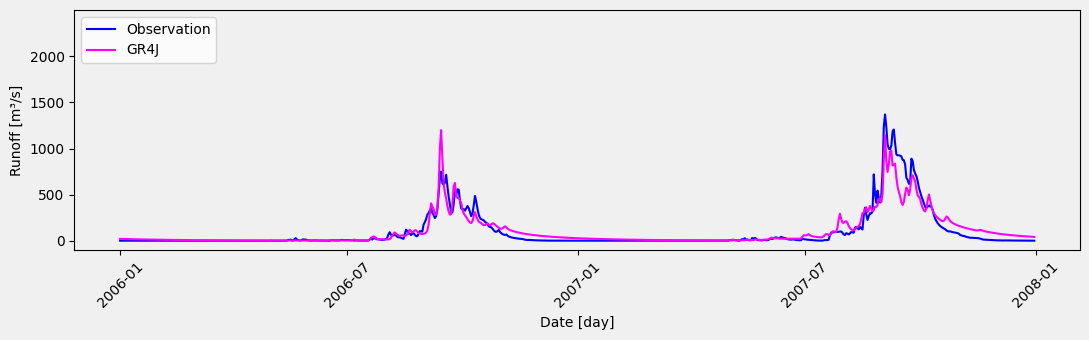

In [ ]:
# Generate dates
time1 = np.datetime64('2006-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharge
ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time, simGR6J_val, 'magenta', label='GR4J', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [m³/s]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-100, 2500)
ax.set_yticks(np.arange(0, 2500, 500))

# Add legend
ax.legend(loc='upper left')

# Show grid
# plt.grid(True)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("Cauqueness_GR4J.jpeg", format='jpeg', dpi=700)

#files.download("Cauqueness_GR4J.jpeg")

ax.grid(False)

# Show plot
plt.show()


In [ ]:
#Calibration
simGR4J = simGR6J.flatten()
print('nashe=',nash_sutcliffe_efficiency(discharge, simGR4J))
print('rmse=',calculate_rmse(discharge, simGR4J))
print('r2=',calculate_r2(discharge, simGR4J))

nashe= 0.7784804655961306
rmse= 110.94378559185685
r2= 0.7967373178156293


In [ ]:
#Validation
simGR4J_val = simGR6J_val.flatten()
print('nashe=',nash_sutcliffe_efficiency(discharge1, simGR4J_val))
print('rmse=',calculate_rmse(discharge1, simGR4J_val))
print('r2=',calculate_r2(discharge1, simGR4J_val))

nashe= 0.8621728559321771
rmse= 79.0378781271973
r2= 0.8766652338603576


In [ ]:
Residu =  discharge - simGR6J
Residu1 = discharge1 - simGR6J_val

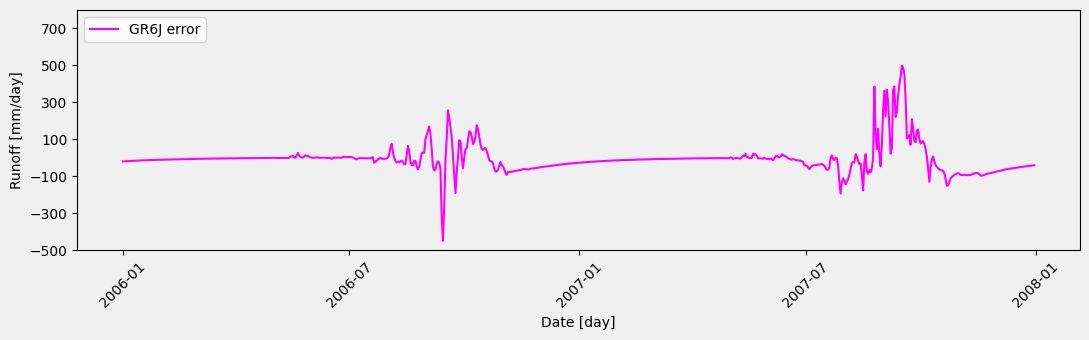

In [ ]:
# Generate dates
time1 = np.datetime64('2006-01-01')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharge
#ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time,Residu1, 'magenta', label='GR6J error', linewidth=1.5)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-500, 800)
ax.set_yticks(np.arange(-500, 800, 200))

# Add legend
ax.legend(loc='upper left')

# Show grid
# plt.grid(True)

# Avoid overlaps
plt.tight_layout()


#files.download("Cauqueness_GR4J.jpeg")

# Show plot
plt.show()


GR6J_KAN

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/KAN')

In [ ]:
pip install optuna

[I 2025-11-19 15:02:40,325] A new study created in memory with name: no-name-9b7b4589-5ad4-4dad-93dc-b2fa07f39ee4
[I 2025-11-19 15:03:36,303] Trial 0 finished with value: 0.2556777000427246 and parameters: {'hidden_dim': 64, 'lr': 0.001, 'epochs': 250, 'batch_size': 256}. Best is trial 0 with value: 0.2556777000427246.
[I 2025-11-19 15:05:24,763] Trial 1 finished with value: 0.23836857080459595 and parameters: {'hidden_dim': 256, 'lr': 0.01, 'epochs': 250, 'batch_size': 256}. Best is trial 0 with value: 0.2556777000427246.
[I 2025-11-19 15:13:11,484] Trial 2 finished with value: -0.07240211963653564 and parameters: {'hidden_dim': 128, 'lr': 0.01, 'epochs': 250, 'batch_size': 4}. Best is trial 0 with value: 0.2556777000427246.
[I 2025-11-19 15:14:33,807] Trial 3 finished with value: 0.2637413740158081 and parameters: {'hidden_dim': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 32}. Best is trial 3 with value: 0.2637413740158081.
[I 2025-11-19 15:15:58,159] Trial 4 finished with value: 

✅ Best hyperparameters: {'hidden_dim': 256, 'lr': 0.01, 'epochs': 250, 'batch_size': 256}
✅ Best validation NSE : 0.29529672861099243
📊 Final NSE (train): 0.3022
📊 Final NSE (val)  : 0.2679


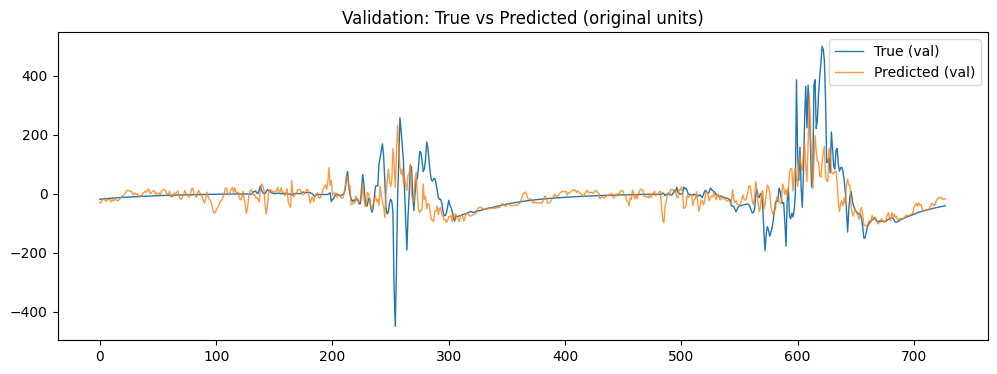

In [ ]:
# ==========================================================
# 🔧 Imports & general settings
# ==========================================================
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/KAN')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import copy
import optuna
import matplotlib.pyplot as plt
import os

from utils import EarlyStopping, KAN, KANLinear, kan_prediction_plots

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 142
np.random.seed(SEED)
torch.manual_seed(SEED)

# ==========================================================
# 1️⃣ NSE
# ==========================================================
def nash_sutcliffe_efficiency(obs, sim):
    obs = np.array(obs)
    sim = np.array(sim)
    return 1 - np.sum((obs - sim) ** 2) / np.sum((obs - np.mean(obs)) ** 2)

# ==========================================================
# 2️⃣ Prepare data with LAG
# ==========================================================
lag = 2  # adjustable

data_train = pd.DataFrame({
    'Qsim': simGR4J,
    'plui': plui,
    'etp': etp,
    'target': Residu
})

data_test = pd.DataFrame({
    'Qsim': simGR4J_val,
    'plui': plui1,
    'etp': etp1,
    'target': Residu1
})

data = pd.concat([data_train, data_test], ignore_index=True)

# --- create lag features if lag >= 1, otherwise keep raw variables ---
if lag >= 1:
        for f in ['Qsim','plui','etp']:
            for l in range(1, lag + 1):
                data[f'{f}_lag{l}'] = data[f].shift(l)
        data = data.dropna().reset_index(drop=True)
else:
        # lag == 0 -> keep raw columns (no shift)
        data = data.reset_index(drop=True)


# ==========================================================
# 3️⃣ Prepare dataset & scaler
# ==========================================================
def Make_tidydata_for_kan(data_df, train_size=1461):
    df = data_df.copy().reset_index(drop=True)
    if train_size >= len(df):
        raise ValueError("train_size too large for dataset size.")

    train_df = df.iloc[:train_size].copy().reset_index(drop=True)
    val_df   = df.iloc[train_size:].copy().reset_index(drop=True)

    # all lag columns as features
    X_cols = [
    'Qsim','plui','etp'
    ] + [c for c in df.columns if c.startswith("Qsim_lag") or c.startswith("plui_lag") or c.startswith("etp_lag")
                         ]
    y_col = 'target'

    # store original target values
    train_df['target_orig'] = train_df[y_col].values
    val_df['target_orig'] = val_df[y_col].values

    # scaler
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    scaler_X.fit(train_df[X_cols])
    scaler_y.fit(train_df[[y_col]])

    train_df[X_cols] = scaler_X.transform(train_df[X_cols])
    val_df[X_cols]   = scaler_X.transform(val_df[X_cols])
    train_df[[y_col]] = scaler_y.transform(train_df[[y_col]])
    val_df[[y_col]]   = scaler_y.transform(val_df[[y_col]])

    return train_df, val_df, scaler_X, scaler_y, X_cols

# ==========================================================
# 4️⃣ DataLoader & prediction
# ==========================================================
def data_loading(Xy_df, X_cols, y_col='target', batch_size=None, shuffle=False):
    X = Xy_df[X_cols].values.astype(np.float32)
    y = Xy_df[y_col].values.astype(np.float32).reshape(-1,1)
    dataset = TensorDataset(torch.tensor(X), torch.tensor(y))
    if batch_size is None:
        batch_size = len(dataset)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

def predict_all(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for Xb, yb in loader:
            y_pred = model(Xb, update_grid=False)
            preds.append(y_pred)
            trues.append(yb)
    preds = torch.cat(preds, dim=0).cpu().numpy().flatten()
    trues = torch.cat(trues, dim=0).cpu().numpy().flatten()
    return preds, trues

# ==========================================================
# 5️⃣ KAN training loop
# ==========================================================
def train_test_loop_for_Q(data_df, epochs, layers_hidden=[1,128,1], lr=0.001,
                          batch_size=None, trial=None, train_size=1461):
    train_df, val_df, scaler_X, scaler_y, X_cols = Make_tidydata_for_kan(data_df, train_size=train_size)
    train_loader = data_loading(train_df, X_cols, batch_size=batch_size, shuffle=True)
    val_loader   = data_loading(val_df, X_cols, batch_size=batch_size, shuffle=False)

    input_size = len(X_cols)
    local_layers_hidden = layers_hidden.copy()
    local_layers_hidden[0] = input_size

    Kan_network = KAN(layers_hidden=local_layers_hidden).to(torch.float32)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(Kan_network.parameters(), lr=lr)
    Kan_network.train()

    best_val_nse = -np.inf
    best_model_state = None

    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = Kan_network(X_batch, update_grid=False)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        y_val_pred_s, y_val_true_s = predict_all(Kan_network, val_loader)
        y_val_pred = scaler_y.inverse_transform(y_val_pred_s.reshape(-1,1)).flatten()
        y_val_true = scaler_y.inverse_transform(y_val_true_s.reshape(-1,1)).flatten()
        nse_val = nash_sutcliffe_efficiency(y_val_true, y_val_pred)

        if nse_val > best_val_nse:
            best_val_nse = nse_val
            best_model_state = copy.deepcopy(Kan_network.state_dict())
            if trial is not None:
                torch.save(best_model_state, f"best_model_trial_{trial.number}.pt")

        if trial is not None:
            trial.report(nse_val, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

    return best_val_nse, scaler_X, scaler_y, X_cols, best_model_state

# ==========================================================
# 6️⃣ Optuna
# ==========================================================
def objective(trial):
    n_units = trial.suggest_categorical("hidden_dim", [8, 16, 32, 64, 128, 256])
    lr = trial.suggest_categorical("lr", [1e-3, 1e-2])
    epochs_trial = trial.suggest_categorical("epochs", [50, 100, 150, 200, 250])
    batch_size_trial = trial.suggest_categorical("batch_size", [4, 8, 16, 32, 64, 128, 256])

    nse_val, *_ = train_test_loop_for_Q(
        data,
        epochs_trial,
        layers_hidden=[1, n_units, 1],
        lr=lr,
        batch_size=batch_size_trial,
        trial=trial
    )

    trial.set_user_attr("model_path", f"best_model_trial_{trial.number}.pt")
    return nse_val

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50, interval_steps=10)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=50)

best_trial = study.best_trial
best_params = best_trial.params
best_path = best_trial.user_attrs["model_path"]

print("✅ Best hyperparameters:", best_params)
print("✅ Best validation NSE :", best_trial.value)

# ==========================================================
# 7️⃣ Load best model & final evaluation (fixed)
# ==========================================================
# 1) Get X_cols (and scalers) exactly as during training
train_df, val_df, scaler_X, scaler_y, X_cols = Make_tidydata_for_kan(data, train_size=1280)
input_dim = len(X_cols)   # IMPORTANT: same as used during training

# 2) Rebuild same architecture as during training
best_layers = [input_dim, best_params["hidden_dim"], 1]
model_final = KAN(layers_hidden=best_layers).to(torch.float32).to(device)

# 3) Load state_dict (with map_location if needed)
state = torch.load(best_path, map_location=device)
model_final.load_state_dict(state)
model_final.eval()

# 4) Prepare dataloaders (use same X_cols and scalers)
train_loader = data_loading(train_df, X_cols, batch_size=best_params["batch_size"], shuffle=False)
val_loader   = data_loading(val_df, X_cols, batch_size=best_params["batch_size"], shuffle=False)


res_pred_train, _ = predict_all(model_final, train_loader)
res_pred_test, _  = predict_all(model_final, val_loader)

res_pred_train = scaler_y.inverse_transform(res_pred_train.reshape(-1,1)).flatten()
res_pred_test  = scaler_y.inverse_transform(res_pred_test.reshape(-1,1)).flatten()
y_train_true = scaler_y.inverse_transform(train_df[['target']]).flatten()
y_val_true   = scaler_y.inverse_transform(val_df[['target']]).flatten()

nse_train = nash_sutcliffe_efficiency(y_train_true, res_pred_train)
nse_val   = nash_sutcliffe_efficiency(y_val_true, res_pred_test)

print(f"📊 Final NSE (train): {nse_train:.4f}")
print(f"📊 Final NSE (val)  : {nse_val:.4f}")

# ==========================================================
# 8️⃣ Visualization
# ==========================================================
plt.figure(figsize=(12,4))
plt.plot(y_val_true, label='True (val)', linewidth=1)
plt.plot(res_pred_test, label='Predicted (val)', linewidth=1, alpha=0.8)
plt.legend()
plt.title('Validation: True vs Predicted (original units)')
plt.show()


##residu plots

In [ ]:
# Validation Performance evaluation

nse_value = nash_sutcliffe_efficiency(Residu1[2:], res_pred_test)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(Residu1[2:], res_pred_test)
print('RMSE =', rmse)

r2 = calculate_r2(Residu1[2:], res_pred_test)
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.2679008111575839
RMSE = 67.43522416236796
R² = 0.27787891926086394


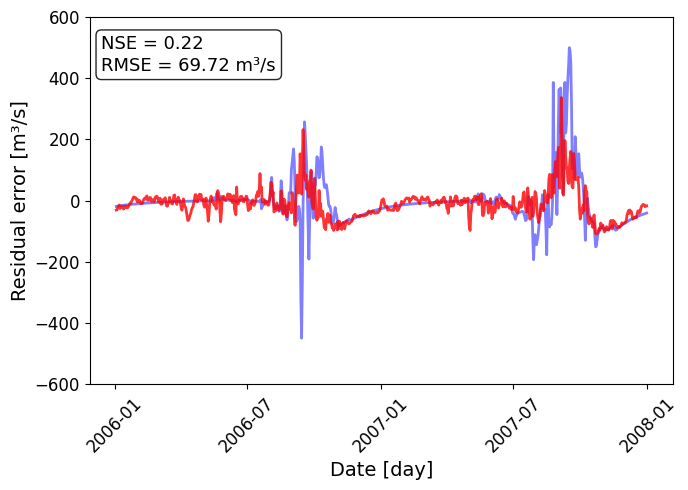

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Generate dates
time1 = np.datetime64('2006-01-03')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(7, 5))

# Plot observed and simulated discharge
ax.plot(time, Residu1[2:], color='b', alpha=0.5, label=r"$\mathrm{Res}^{\mathrm{GR6J}}$", linewidth=2)
ax.plot(time, res_pred_test, color='red', alpha=0.8, label='Prediction (WKAN)', linewidth=2)

# Annotation
plt.text(0.02, 0.95, f"NSE = {0.22}\nRMSE = {69.72} m³/s",
         transform=plt.gca().transAxes, fontsize=13,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.85))

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45, fontsize=12)
ax.set_xlabel('Date [day]', fontsize=14)

# Y-axis parameters
ax.set_ylabel('Residual error [m³/s]', fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-600, 600)
ax.set_yticks(np.arange(-600, 601, 200))

# Add legend
#ax.legend(fontsize=13)

# Remove grid
ax.grid(False)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("Res_KAN.jpeg", format='jpeg', dpi=700)

# Télécharger le fichier dans Google Colab
from google.colab import files
#files.download('Res_KAN.jpeg')

# Show plot
plt.show()


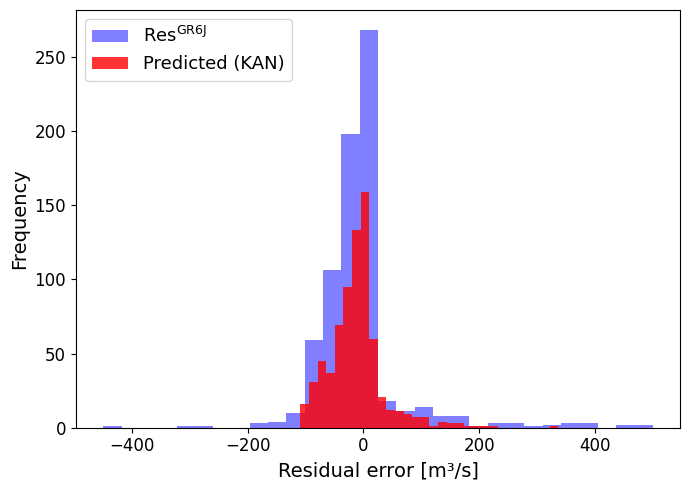

In [ ]:
# Plot
plt.figure(figsize=(7, 5))
plt.hist(Residu1, bins=30, alpha=0.5, label=r"$\mathrm{Res}^{\mathrm{GR6J}}$", color='b')
plt.hist(res_pred_test, bins=30, alpha=0.8, label='Predicted (KAN)', color='red')

# Labels
plt.xlabel('Residual error [m³/s]', fontsize=14)
plt.ylabel('Frequency', fontsize=14)


plt.legend(loc='upper left', fontsize=13)
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

# Save figure
plt.savefig("His_KAN_save.jpeg", format='jpeg', dpi=700)
#files.download('His_KAN_save.jpeg')

plt.show()


Data reconstruction

In [ ]:
final_pred = simGR6J[2:] + res_pred_train[:-2]
final_pred1 = simGR6J_val[2:] + res_pred_test

In [ ]:
# Training Performance evaluation

nse_value = nash_sutcliffe_efficiency(discharge[2:],final_pred)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge[2:],final_pred)
print('RMSE =', rmse)

r2 = calculate_r2(discharge[2:],final_pred)
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.8481705752708149
RMSE = 91.89743472081483
R² = 0.8491872757700933


In [ ]:
# Validation Performance evaluation

nse_value = nash_sutcliffe_efficiency(discharge1[2:], final_pred1)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1[2:], final_pred1)
print('RMSE =', rmse)

r2 = calculate_r2(discharge1[2:], final_pred1)
print('R² =', r2)

Nash-Sutcliffe Efficiency (NSE): 0.8998896801786423
RMSE = 67.43522416236796
R² = 0.9004106159432926


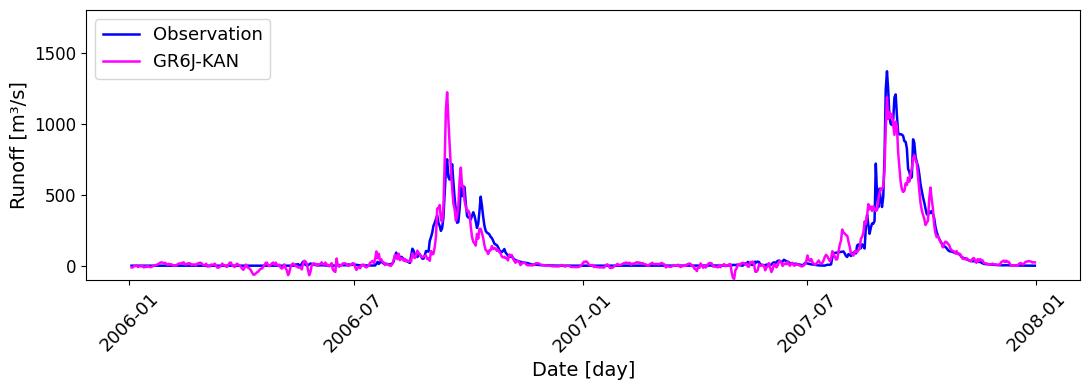

In [ ]:
import matplotlib.dates as mdates
import numpy as np
import matplotlib.pyplot as plt

# Generate dates
time1 = np.datetime64('2006-01-03')
time2 = np.datetime64('2007-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create figure and axis
fig, ax = plt.subplots(figsize=(11, 4))

# Plot observed and simulated discharge
ax.plot(time, discharge1[2:], 'b', label='Observation', linewidth=1.8)
ax.plot(time, final_pred1, 'magenta', label='GR6J-KAN', linewidth=1.8)

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45, fontsize=13)
ax.set_xlabel('Date [day]', fontsize=14)

# Y-axis parameters
ax.set_ylabel('Runoff [m³/s]', fontsize=14)
ax.tick_params(axis='y', labelcolor='black', labelsize=12)
ax.set_ylim(-100, 1800)
ax.set_yticks(np.arange(0, 1800, 500))

# Add legend
ax.legend(loc='upper left', fontsize=13)

# Disable grid
ax.grid(False)

# Avoid overlaps
plt.tight_layout()

# Save figure
plt.savefig("GR6J_KAN_save.jpeg", format='jpeg', dpi=700)

#files.download('GR6J_KAN_save.jpeg')

# Show plot
plt.show()


In [ ]:
# Create a DataFrame to save the mean trajectory to an Excel file
df_mean_trajectory = pd.DataFrame({'GR6J_KAN_save': final_pred1})

# Save to an Excel file
df_mean_trajectory.to_excel('GR6J_KAN_save.xlsx', index=False)

# Download the file in Google Colab
#files.download('GR6J_KAN_save.xlsx')

(t-2) GR6J_KAN : NSE_res=0.327

Nash-Sutcliffe Efficiency (NSE): 0.807432125639784
RMSE = 103.4945149351235
R² = 0.8080205231835982

Nash-Sutcliffe Efficiency (NSE): 0.908017405628967
RMSE = 64.63983042222485
R² = 0.9096915718915498


(t-2) GR6J_KAN_P_PET

Nash-Sutcliffe Efficiency (NSE): 0.8481705752708149
RMSE = 91.89743472081483
R² = 0.8491872757700933

Nash-Sutcliffe Efficiency (NSE): 0.8998896801786423
RMSE = 67.43522416236796
R² = 0.9004106159432926